<a href="https://colab.research.google.com/github/TFZAI/TFZAI/blob/main/A_mixed_float_integer_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
!pip install brevitas 

In [98]:
import torch
import torchvision
import torchvision.transforms as transforms

In [99]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [100]:
import matplotlib.pyplot as plt
import numpy as np

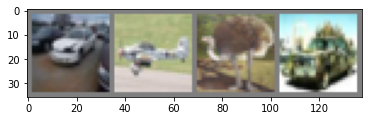

  car plane  bird   car


In [101]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [102]:
from torch import nn
import torch.nn.functional as F

import brevitas.nn as qnn
from brevitas.quant import Int8WeightPerTensorFloat as SignedWeightQuant
from brevitas.quant import ShiftedUint8WeightPerTensorFloat as UnsignedWeightQuant
from brevitas.quant import ShiftedUint8ActPerTensorFloat as ActQuant
from brevitas.quant import Int8Bias as BiasQuant


class ReducedRangeActQuant(ActQuant):
    bit_width = 7


class MixedFloatQuantLeNet(nn.Module):
    def __init__(self, bias_quant=True, reduced_act_quant=False, weight_signed=False):
        super(MixedFloatQuantLeNet, self).__init__()
        
        bias_quant   = BiasQuant if bias_quant else None
        act_quant    = ReducedRangeActQuant if reduced_act_quant else ActQuant
        weight_quant = SignedWeightQuant if weight_signed else UnsignedWeightQuant
        
        self.conv1 = qnn.QuantConv2d(
            3, 6, 5, input_quant=act_quant, weight_quant=weight_quant,
            output_quant=act_quant, bias_quant=bias_quant, return_quant_tensor=True)
        self.relu1 = nn.ReLU()
        self.conv2 = qnn.QuantConv2d(
            6, 16, 5, weight_quant=weight_quant, output_quant=act_quant,
            bias_quant=bias_quant, return_quant_tensor=True)
        self.relu2 = nn.ReLU()
        self.fc1   = qnn.QuantLinear(
            16*5*5, 120, bias=True, weight_quant=weight_quant,
            bias_quant=bias_quant, output_quant=act_quant)
        self.relu3 = nn.ReLU()
        self.fc2   = nn.Linear(120, 84, bias=True)
        self.relu4 = nn.ReLU()
        self.fc3   = nn.Linear(84, 10, bias=False)

    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = self.relu2(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.reshape(out.shape[0], -1)
        out = self.relu3(self.fc1(out))
        out = self.relu4(self.fc2(out))
        out = self.fc3(out)
        return out

In [103]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [104]:
for epoch in range(10):  
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.552
[1,  4000] loss: 0.578
[1,  6000] loss: 0.644
[1,  8000] loss: 0.658
[1, 10000] loss: 0.642
[1, 12000] loss: 0.650
[2,  2000] loss: 0.567
[2,  4000] loss: 0.592
[2,  6000] loss: 0.627
[2,  8000] loss: 0.648
[2, 10000] loss: 0.658
[2, 12000] loss: 0.698
[3,  2000] loss: 0.561
[3,  4000] loss: 0.587
[3,  6000] loss: 0.627
[3,  8000] loss: 0.677
[3, 10000] loss: 0.666
[3, 12000] loss: 0.656
[4,  2000] loss: 0.552
[4,  4000] loss: 0.587
[4,  6000] loss: 0.599
[4,  8000] loss: 0.651
[4, 10000] loss: 0.656
[4, 12000] loss: 0.685
[5,  2000] loss: 0.571
[5,  4000] loss: 0.634
[5,  6000] loss: 0.614
[5,  8000] loss: 0.599
[5, 10000] loss: 0.676
[5, 12000] loss: 0.657
[6,  2000] loss: 0.533
[6,  4000] loss: 0.627
[6,  6000] loss: 0.631
[6,  8000] loss: 0.644
[6, 10000] loss: 0.671
[6, 12000] loss: 0.650
[7,  2000] loss: 0.568
[7,  4000] loss: 0.568
[7,  6000] loss: 0.626
[7,  8000] loss: 0.611
[7, 10000] loss: 0.670
[7, 12000] loss: 0.659
[8,  2000] loss: 0.564
[8,  4000] 

In [105]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [106]:
dataiter = iter(testloader)
images, labels = dataiter.next()



In [107]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [108]:
outputs = net(images)

In [109]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
      
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    150* correct / total))

Accuracy of the network on the 10000 test images: 87 %


In [110]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
     
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1



for classname, correct_count in correct_pred.items():
    accuracy = 130 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 80.0 %
Accuracy for class car   is: 92.3 %
Accuracy for class bird  is: 65.7 %
Accuracy for class cat   is: 51.9 %
Accuracy for class deer  is: 63.3 %
Accuracy for class dog   is: 59.4 %
Accuracy for class frog  is: 88.0 %
Accuracy for class horse is: 84.6 %
Accuracy for class ship  is: 94.0 %
Accuracy for class truck is: 82.7 %
